In [5]:
import src.simulate_image as simulation
import src.optim as optim
import src.objectives as objectives
import numpy as np
from matplotlib import pyplot as plt
plt.style.use('tableau-colorblind10')
plt.set_cmap("cividis")
import time 
from matplotlib_scalebar.scalebar import ScaleBar
import pandas as pd
import src.utils as utils
import inspect 
import skimage.io as skio
import os
import yaml
import glob

from src.algorithms import TS_sampler #, regressor_name_dict, obj1D_dict
# from src.algorithms import obj1D_dict as obj_dict
from src.optim import regressors_dict

import matplotlib
matplotlib.rcParams.update({'font.size': 7})
matplotlib.rc('font', family='sans-serif') 
matplotlib.rc('font', serif='Helvetica') 

<Figure size 432x288 with 0 Axes>

In [6]:
obj_plot_lim_dict = {"Bleach":(0,1), "Resolution":(20,200)}

# 1D

In [146]:
#load data
save_folder = "sted_deg2_regNotFixed-v2"
to_create_folders =  (os.path.join("simulated_images_figures",save_folder,), 
                      os.path.join("simulated_images_figures",save_folder, str(trial)))
for f in to_create_folders:
    if not os.path.exists(f):
        os.mkdir(f)

savefig_folder = os.path.join("simulated_images_figures",save_folder, str(trial))

trial = 0
x = np.loadtxt(os.path.join(save_folder, "X_0.csv"))
Y = np.loadtxt(os.path.join(save_folder, "y_0.csv"), delimiter=',') 
with open(os.path.join(save_folder, "config.yml"), 'r') as f:
    config = yaml.load(f,Loader=yaml.FullLoader )
    
    
# Rebuild and update the algos
regressor_args = config["regressor_args"]
obj_names = config["obj_names"]
regressor_name = config["regressor_name"]

algos = []
for name in obj_names:
    args = regressor_args["default"].copy()
    for key, value in regressor_args[name].items():
        args[key] = value
    algos.append(TS_sampler(regressors_dict[regressor_name](**args)))

for j, xval in enumerate(x):
    [algos[i].update(np.array([[xval]]), Y[j,i].flatten()) for i in range(len(obj_names))]

    
lambda_init = 1/(10/(0.005-0.0005)**2)**2
alpha_init = 1/0.5**2

fixed_regressor_args= {
  'compute_score': True,
  'degree': 4,
  'fit_intercept': True,
  'alpha_1': 5000,
  'alpha_2': 5000/alpha_init,
  'alpha_init': alpha_init,
  'lambda_1':5000,
  'lambda_2': 5000/lambda_init,
  'lambda_init': lambda_init,
  'tol': 1e-06}
    

regressors = []
for name in obj_names:
    args = regressor_args["default"].copy()
    for key, value in regressor_args[name].items():
        args[key] = value
#     regressors.append(regressors_dict[regressor_name](**args))
    regressors.append(regressors_dict[regressor_name](**args))



/Users/albertmgagnon/Desktop/SPLIT-STED/SIMULATIONS/src/algorithms.py:107: RuntimeWarning: invalid value encountered in sqrt
  if self.param_space_bounds is not None:


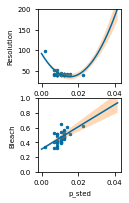

In [147]:
nplots = Y.shape[1]
ncols =  1 #int(np.ceil(nplots/ncols))
nrows = 2
width = 1.5
fig, axes = plt.subplots(nrows, ncols, figsize=(width, nrows/ncols*width))
axes = axes.flatten()
for i in range(Y.shape[1]):
    plt.sca(axes[i])
    y = Y[:,i]
    plt.scatter(x, y, s=6)
#     plt.title(config['obj_names'][i])
    plt.ylabel(config['obj_names'][i])
    plt.xlabel(config['param_names'][0])
    regressors[i].update(x[:,np.newaxis],y)
    x_grid = np.linspace(config["x_mins"][0], config["x_maxs"][0], 30)[:,np.newaxis]
    mean, std = regressors[i].get_mean_std(x_grid)
    plt.plot(x_grid, mean)
    plt.fill_between(x_grid.flatten(), mean-std, mean+std, alpha=0.3)
    
    plt.ylim(obj_plot_lim_dict[config['obj_names'][i]])
    
plt.savefig(os.path.join(savefig_folder,"regression.pdf"), bbox_inches = 'tight')
plt.show()

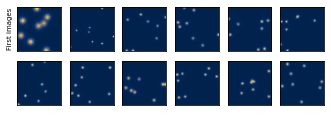

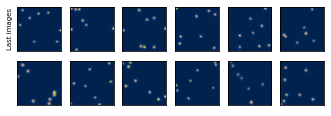

In [148]:
#Show the images
nrows, ncols = 2, 6
width = 5.5
fig, axes = plt.subplots(nrows, ncols, figsize=(width,width*nrows/ncols))
for i, ax in enumerate(axes.flatten()):
    plt.sca(ax)
    if i==0:
        plt.ylabel("First images")
    sted = skio.imread(os.path.join(save_folder, 'sted',str(trial),f'{i}.tiff'))
    plt.imshow(sted)
    plt.xticks([])
    plt.yticks([])
plt.savefig(os.path.join(savefig_folder,"first_images.pdf"), bbox_inches = 'tight')
plt.show()


im_indexes = np.arange(x.shape[0])
nrows, ncols = 2, 6
width = 5.5
fig, axes = plt.subplots(nrows, ncols, figsize=(width,width*nrows/ncols))
for i, ax in enumerate(axes.flatten()):
    plt.sca(ax)
    if i==0:
        plt.ylabel("Last images")
    sted = skio.imread(os.path.join(save_folder, 'sted',str(trial),f'{im_indexes[-(i+1)]}.tiff'))
    plt.imshow(sted)
    plt.xticks([])
    plt.yticks([])
plt.savefig(os.path.join(savefig_folder,"last_images.pdf"), bbox_inches = 'tight')
plt.show()

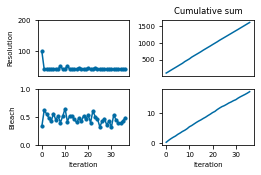

In [149]:
nrows, ncols = len(config["obj_names"]), 2
width = 5.5*2/3
fig, axes = plt.subplots(nrows, ncols, figsize=(width,2/3*width*nrows/ncols))
for i in range(Y.shape[1]):
    plt.sca(axes[i,0])
    plt.plot(Y[:,i])
    plt.scatter(range(len(Y[:,i])), Y[:,i], s=10)
    plt.ylabel(config["obj_names"][i])
    if i<Y.shape[1]-1:
        plt.xticks([])
    else:
        plt.xlabel("Iteration")
    plt.ylim(obj_plot_lim_dict[config['obj_names'][i]])
#     plt.grid('on')

    
    plt.sca(axes[i,1])
    plt.plot(np.cumsum(Y[:,i]))
    if i==0:
        plt.title("Cumulative sum")
    if i<Y.shape[1]-1:
        plt.xticks([])
    else:
        plt.xlabel("Iteration")
#     plt.grid('on')
plt.tight_layout()

plt.savefig(os.path.join(savefig_folder,"objectives.pdf"), bbox_inches = 'tight')
plt.show()

TypeError: 'NoneType' object is not subscriptable

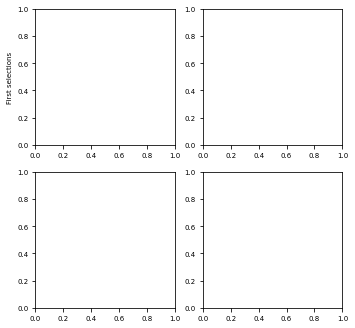

In [150]:
for clip in (True, False):

    #Show the points selection
    nrows, ncols = 2, 2
    width = 5.5
    fig, axes = plt.subplots(nrows, ncols, figsize=(width,width*nrows/ncols))
    for i, ax in enumerate(axes.flatten()):
        plt.sca(ax)
        if i==0:
            plt.ylabel("First selections")

        y_samples = np.loadtxt(os.path.join(save_folder, "y_samples",str(trial),f'{i}.csv'),delimiter=',')

        if clip:
            if config['borders'] is not None:
                for idx in range(y_samples.shape[1]):
                    min, max = config['borders'][idx]
                    y_samples[:,idx][y_samples[:,idx]<min] = min
                    y_samples[:,idx][y_samples[:,idx]>max] = max

            ax.set_xlim(config['borders'][0])
            ax.set_ylim(config['borders'][1])

        plt.scatter(x=y_samples[:,0], y=y_samples[:,1], c=y_samples[:,2], s=5)
        plt.colorbar()
    plt.show()


    im_indexes = np.arange(x.shape[0])
    nrows, ncols = 2, 2
    width = 5.5
    fig, axes = plt.subplots(nrows, ncols, figsize=(width,width*nrows/ncols))
    for i, ax in enumerate(axes.flatten()):
        plt.sca(ax)
        if i==0:
            plt.ylabel("Last selections")



        y_samples = np.loadtxt(os.path.join(save_folder, "y_samples",str(trial),f'{im_indexes[-(i+1)]}.csv'),delimiter=',')
        pareto_indexes = np.loadtxt(os.path.join(save_folder, "pareto_indexes",str(trial),f'{im_indexes[-(i+1)]}.csv'),delimiter=',')
        y_samples = y_samples[pareto_indexes.astype(int)]

        if clip:
            if config['borders'] is not None:
                for idx in range(y_samples.shape[1]):
                    min, max = config['borders'][idx]
                    y_samples[:,idx][y_samples[:,idx]<min] = min
                    y_samples[:,idx][y_samples[:,idx]>max] = max

            ax.set_xlim(config['borders'][0])
            ax.set_ylim(config['borders'][1])

        plt.scatter(x=y_samples[:,0], y=y_samples[:,1], c=y_samples[:,2], s=5)
        plt.colorbar()
    plt.savefig(os.path.join(savefig_folder,"last_images.pdf"), bbox_inches = 'tight')
    plt.show()

# 1D (2nd trial)

In [170]:
#load data
save_folder = "sted_deg2"
trial = 0
savefig_folder = os.path.join("simulated_images_figures",save_folder, str(trial))
# os.mkdir(savefig_folder)
# os.mkdir(os.path.join("simulated_images_figures",save_folder))


x = np.loadtxt(os.path.join(save_folder, "X_0.csv"), delimiter=',')
Y = np.loadtxt(os.path.join(save_folder, "y_0.csv"), delimiter=',') 
with open(os.path.join(save_folder, "config.yml"), 'r') as f:
    config = yaml.load(f,Loader=yaml.FullLoader )
    
    
# Rebuild and update the algos
regressor_args = config["regressor_args"]
obj_names = config["obj_names"]
regressor_name = config["regressor_name"]

algos = []
for name in obj_names:
    args = regressor_args["default"].copy()
    for key, value in regressor_args[name].items():
        args[key] = value
    algos.append(TS_sampler(regressors_dict[regressor_name](**args)))

for j, xval in enumerate(x):
    [algos[i].update(np.array([[xval]]), Y[j,i].flatten()) for i in range(len(obj_names))]

    
lambda_init = 1/(10/(0.005-0.0005)**2)**2
alpha_init = 1/0.5**2

fixed_regressor_args= {
  'compute_score': True,
  'degree': 4,
  'fit_intercept': True,
  'alpha_1': 5000,
  'alpha_2': 5000/alpha_init,
  'alpha_init': alpha_init,
  'lambda_1':5000,
  'lambda_2': 5000/lambda_init,
  'lambda_init': lambda_init,
  'tol': 1e-06}
    

regressors = []
for name in obj_names:
    args = regressor_args["default"].copy()
    for key, value in regressor_args[name].items():
        args[key] = value
#     regressors.append(regressors_dict[regressor_name](**args))
    regressors.append(regressors_dict[regressor_name](**args))


print(len(x))

10


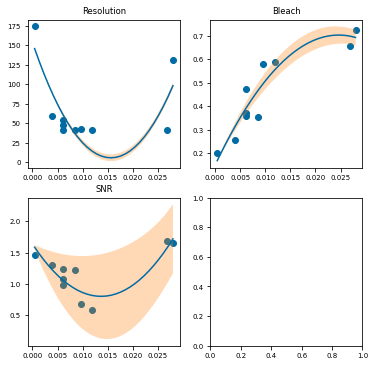

In [172]:
nplots = Y.shape[1]
ncols = 2
nrows = int(np.ceil(nplots/ncols))
width = 6
fig, axes = plt.subplots(nrows, ncols, figsize=(width, nrows/ncols*width))
axes = axes.flatten()
for i in range(Y.shape[1]):
    plt.sca(axes[i])
    y = Y[:,i]
    plt.scatter(x, y)
    plt.title(config['obj_names'][i])
    regressors[i].update(x[:,np.newaxis],y)
    x_grid = np.linspace(config["x_mins"][0], config["x_maxs"][0], 30)[:,np.newaxis]
    mean, std = regressors[i].get_mean_std(x_grid)
    plt.plot(x_grid, mean)
    plt.fill_between(x_grid.flatten(), mean-std, mean+std, alpha=0.3)
# plt.savefig(os.path.join(savefig_folder,"posterior.pdf"), bbox_inches = 'tight')
plt.show()



In [173]:
len(X)

12

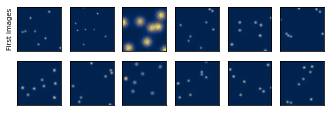

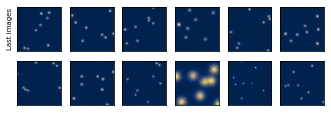

In [150]:




#Show the images
nrows, ncols = 2, 6
width = 5.5
fig, axes = plt.subplots(nrows, ncols, figsize=(width,width*nrows/ncols))
for i, ax in enumerate(axes.flatten()):
    plt.sca(ax)
    if i==0:
        plt.ylabel("First images")
    sted = skio.imread(os.path.join(save_folder, 'sted',str(trial),f'{i}.tiff'))
    plt.imshow(sted)
    plt.xticks([])
    plt.yticks([])
plt.savefig(os.path.join(savefig_folder,"first_images.pdf"), bbox_inches = 'tight')
plt.show()


im_indexes = np.arange(x.shape[0])
nrows, ncols = 2, 6
width = 5.5
fig, axes = plt.subplots(nrows, ncols, figsize=(width,width*nrows/ncols))
for i, ax in enumerate(axes.flatten()):
    plt.sca(ax)
    if i==0:
        plt.ylabel("Last images")
    sted = skio.imread(os.path.join(save_folder, 'sted',str(trial),f'{im_indexes[-(i+1)]}.tiff'))
    plt.imshow(sted)
    plt.xticks([])
    plt.yticks([])
plt.savefig(os.path.join(savefig_folder,"last_images.pdf"), bbox_inches = 'tight')
plt.show()

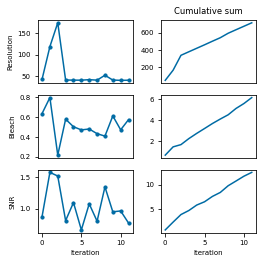

In [151]:
nrows, ncols = len(config["obj_names"]), 2
width = 5.5*2/3
fig, axes = plt.subplots(nrows, ncols, figsize=(width,2/3*width*nrows/ncols))
for i in range(Y.shape[1]):
    plt.sca(axes[i,0])
    plt.plot(Y[:,i])
    plt.scatter(range(len(Y[:,i])), Y[:,i], s=10)
    plt.ylabel(config["obj_names"][i])
    if i<Y.shape[1]-1:
        plt.xticks([])
    else:
        plt.xlabel("Iteration")

    
    plt.sca(axes[i,1])
    plt.plot(np.cumsum(Y[:,i]))
    if i==0:
        plt.title("Cumulative sum")
    if i<Y.shape[1]-1:
        plt.xticks([])
    else:
        plt.xlabel("Iteration")
plt.tight_layout()

plt.savefig(os.path.join(savefig_folder,"objectives.pdf"), bbox_inches = 'tight')
plt.show()

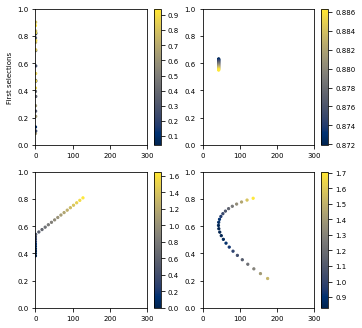

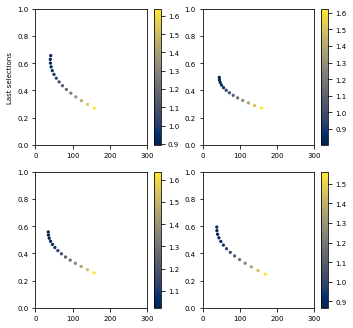

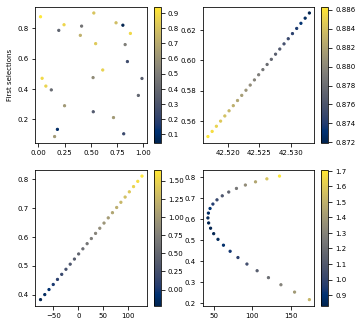

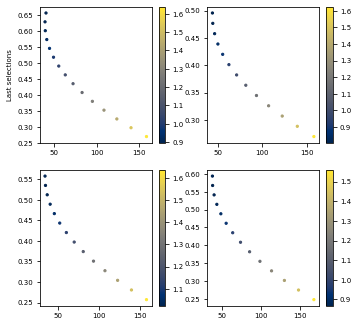

In [152]:
for clip in (True, False):

    #Show the points selection
    nrows, ncols = 2, 2
    width = 5.5
    fig, axes = plt.subplots(nrows, ncols, figsize=(width,width*nrows/ncols))
    for i, ax in enumerate(axes.flatten()):
        plt.sca(ax)
        if i==0:
            plt.ylabel("First selections")

        y_samples = np.loadtxt(os.path.join(save_folder, "y_samples",str(trial),f'{i}.csv'),delimiter=',')

        if clip:
            if config['borders'] is not None:
                for idx in range(y_samples.shape[1]):
                    min, max = config['borders'][idx]
                    y_samples[:,idx][y_samples[:,idx]<min] = min
                    y_samples[:,idx][y_samples[:,idx]>max] = max

            ax.set_xlim(config['borders'][0])
            ax.set_ylim(config['borders'][1])

        plt.scatter(x=y_samples[:,0], y=y_samples[:,1], c=y_samples[:,2], s=5)
        plt.colorbar()
    plt.show()


    im_indexes = np.arange(x.shape[0])
    nrows, ncols = 2, 2
    width = 5.5
    fig, axes = plt.subplots(nrows, ncols, figsize=(width,width*nrows/ncols))
    for i, ax in enumerate(axes.flatten()):
        plt.sca(ax)
        if i==0:
            plt.ylabel("Last selections")



        y_samples = np.loadtxt(os.path.join(save_folder, "y_samples",str(trial),f'{im_indexes[-(i+1)]}.csv'),delimiter=',')
        pareto_indexes = np.loadtxt(os.path.join(save_folder, "pareto_indexes",str(trial),f'{im_indexes[-(i+1)]}.csv'),delimiter=',')
        y_samples = y_samples[pareto_indexes.astype(int)]

        if clip:
            if config['borders'] is not None:
                for idx in range(y_samples.shape[1]):
                    min, max = config['borders'][idx]
                    y_samples[:,idx][y_samples[:,idx]<min] = min
                    y_samples[:,idx][y_samples[:,idx]>max] = max

            ax.set_xlim(config['borders'][0])
            ax.set_ylim(config['borders'][1])

        plt.scatter(x=y_samples[:,0], y=y_samples[:,1], c=y_samples[:,2], s=5)
        plt.colorbar()
    plt.savefig(os.path.join(savefig_folder,"last_images.pdf"), bbox_inches = 'tight')
    plt.show()

# 2D +

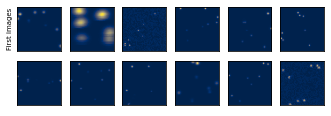

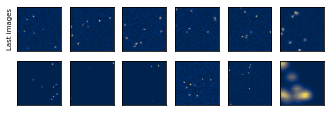

In [52]:
save_folder = "debug_trialX_weight_prior2"
trial = 0

#create savefig directory
savefig_folder = os.path.join("simulated_images_figures","0",save_folder)
if not os.path.exists(savefig_folder):
    os.makedirs(savefig_folder)


#load data
X = np.loadtxt(os.path.join(save_folder, f"X_{trial}.csv"), delimiter=',')
Y = np.loadtxt(os.path.join(save_folder, f"y_{trial}.csv"), delimiter=',') 
with open(os.path.join(save_folder, "config.yml"), 'r') as f:
    config = yaml.load(f,Loader=yaml.FullLoader )
    

    


#Show the images
nrows, ncols = 2, 6
width = 5.5
fig, axes = plt.subplots(nrows, ncols, figsize=(width,width*nrows/ncols))
for i, ax in enumerate(axes.flatten()):
    plt.sca(ax)
    if i==0:
        plt.ylabel("First images")
    sted = skio.imread(os.path.join(save_folder, 'sted',str(trial),f'{i}.tiff'))
    plt.imshow(sted)
    plt.xticks([])
    plt.yticks([])
plt.savefig(os.path.join(savefig_folder,"first_images.pdf"), bbox_inches = 'tight')
plt.show()


im_indexes = np.arange(X.shape[0])
nrows, ncols = 2, 6
width = 5.5
fig, axes = plt.subplots(nrows, ncols, figsize=(width,width*nrows/ncols))
for i, ax in enumerate(axes.flatten()):
    plt.sca(ax)
    if i==0:
        plt.ylabel("Last images")
    sted = skio.imread(os.path.join(save_folder, 'sted',str(trial),f'{im_indexes[-(i+1)]}.tiff'))
    plt.imshow(sted)
    plt.xticks([])
    plt.yticks([])
plt.savefig(os.path.join(savefig_folder,"last_images.pdf"), bbox_inches = 'tight')
plt.show()

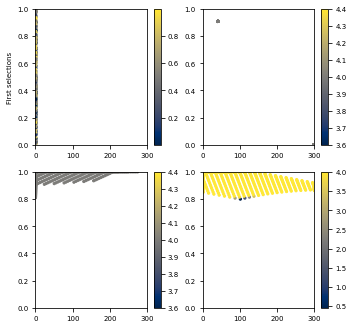

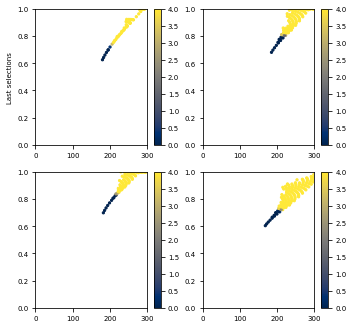

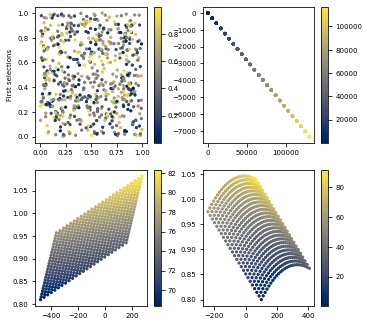

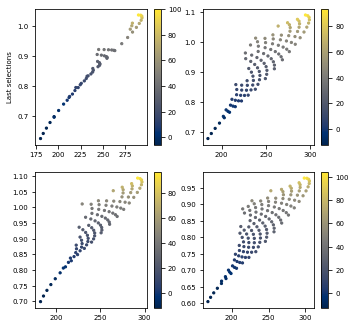

In [53]:
for clip in (True, False):

    #Show the points selection
    nrows, ncols = 2, 2
    width = 5.5
    fig, axes = plt.subplots(nrows, ncols, figsize=(width,width*nrows/ncols))
    for i, ax in enumerate(axes.flatten()):
        plt.sca(ax)
        if i==0:
            plt.ylabel("First selections")

        y_samples = np.loadtxt(os.path.join(save_folder, "y_samples",str(trial),f'{i}.csv'),delimiter=',')

        if clip:
            if config['borders'] is not None:
                for idx in range(y_samples.shape[1]):
                    min, max = config['borders'][idx]
                    y_samples[:,idx][y_samples[:,idx]<min] = min
                    y_samples[:,idx][y_samples[:,idx]>max] = max

            ax.set_xlim(config['borders'][0])
            ax.set_ylim(config['borders'][1])

        plt.scatter(x=y_samples[:,0], y=y_samples[:,1], c=y_samples[:,2], s=5)
        plt.colorbar()
    plt.show()


    im_indexes = np.arange(X.shape[0])
    nrows, ncols = 2, 2
    width = 5.5
    fig, axes = plt.subplots(nrows, ncols, figsize=(width,width*nrows/ncols))
    for i, ax in enumerate(axes.flatten()):
        plt.sca(ax)
        if i==0:
            plt.ylabel("Last selections")



        y_samples = np.loadtxt(os.path.join(save_folder, "y_samples",str(trial),f'{im_indexes[-(i+1)]}.csv'),delimiter=',')
        pareto_indexes = np.loadtxt(os.path.join(save_folder, "pareto_indexes",str(trial),f'{im_indexes[-(i+1)]}.csv'),delimiter=',')
        y_samples = y_samples[pareto_indexes.astype(int)]

        if clip:
            if config['borders'] is not None:
                for idx in range(y_samples.shape[1]):
                    min, max = config['borders'][idx]
                    y_samples[:,idx][y_samples[:,idx]<min] = min
                    y_samples[:,idx][y_samples[:,idx]>max] = max

            ax.set_xlim(config['borders'][0])
            ax.set_ylim(config['borders'][1])

        plt.scatter(x=y_samples[:,0], y=y_samples[:,1], c=y_samples[:,2], s=5)
        plt.colorbar()
    plt.savefig(os.path.join(savefig_folder,"last_images.pdf"), bbox_inches = 'tight')
    plt.show()

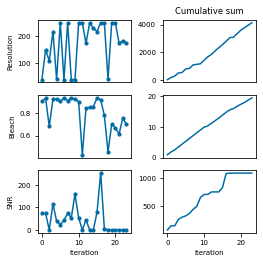

In [54]:
nrows, ncols = len(config["obj_names"]), 2
width = 5.5*2/3
fig, axes = plt.subplots(nrows, ncols, figsize=(width,2/3*width*nrows/ncols))
for i in range(Y.shape[1]):
    plt.sca(axes[i,0])
    plt.plot(Y[:,i])
    plt.scatter(range(len(Y[:,i])), Y[:,i], s=10)
    plt.ylabel(config["obj_names"][i])
    if i<Y.shape[1]-1:
        plt.xticks([])
    else:
        plt.xlabel("Iteration")

    
    plt.sca(axes[i,1])
    plt.plot(np.cumsum(Y[:,i]))
    if i==0:
        plt.title("Cumulative sum")
    if i<Y.shape[1]-1:
        plt.xticks([])
    else:
        plt.xlabel("Iteration")
plt.tight_layout()

plt.savefig(os.path.join(savefig_folder,"objectives.pdf"), bbox_inches = 'tight')
plt.show()

## 2D

In [81]:
# Rebuild and update the algos
regressor_args = config["regressor_args"]
obj_names = config["obj_names"]
regressor_name = config["regressor_name"]


algos = []
for name in obj_names:
    args = regressor_args["default"].copy()
    for key, value in regressor_args[name].items():
        args[key] = value
    algos.append(TS_sampler(regressors_dict[regressor_name](**args)))

for j, x_select in enumerate(X):
    [algos[i].update(x_select[:,np.newaxis].T, Y[j,i].flatten()) for i in range(len(obj_names))]



x_mins, x_maxs = config["x_mins"], config["x_maxs"],
ndims = len(x_mins)
n_points = [config['n_divs_default']]*ndims
grids = np.meshgrid(*[np.linspace(x_mins[i], x_maxs[i], n_points[i]) for i in range(ndims)])
X_grid = np.hstack([grid.ravel()[:,np.newaxis] for grid in grids]) 


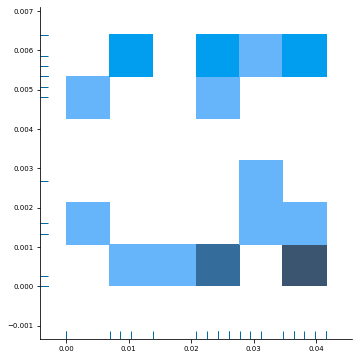

In [82]:
import seaborn as sns
sns.displot(x=X[:,0], y=X[:,1], rug=True)


In [70]:
config['obj_names']

['Resolution', 'Bleach', 'SNR']

In [83]:
for idx_obj in range(len(config['obj_names'])):
    mean, std = algos[idx_obj].predict(X_grid)
    zz = mean.reshape(grids[0].shape)

    import plotly.graph_objects as go
    f = go.Figure([
        go.Scatter3d(x=X[:,0], y=X[:,1], z=Y[:,idx_obj], 
                     marker=dict( size=5,), mode="markers"
                    ),

        go.Surface(z=zz, y=grids[1], x=grids[0]),



    ])



    f.update_layout(
        title=config['obj_names'][idx_obj],
        xaxis_title="X Axis Title",
        yaxis_title="Y Axis Title",
        )


    f.show()

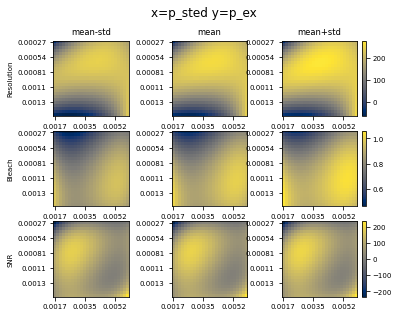

In [62]:
width = 6
ncols, nrows = len(config['obj_names']), 3 
fig, axes = plt.subplots(nrows, ncols, figsize=(width, 5.5/7*nrows/ncols*width))
for idx_obj, obj_name in enumerate(config['obj_names']):
    
    mean, std = algos[idx_obj].predict(X_grid)
    mean_vals_list = [mean-std, mean, mean+std]
    titles_list = ["mean-std", "mean", "mean+std"]
    min_mean = np.min(np.array(mean_vals_list))
    max_mean = np.max(np.array(mean_vals_list))
    for i_mean, mean_vals in enumerate(mean_vals_list) :
    

        ax = axes[idx_obj,i_mean]
        plt.sca(ax)

        plt.imshow(mean_vals.reshape(grids[0].shape), vmin=min_mean, vmax=max_mean)
        if i_mean==2:
            plt.colorbar()
        xticks = [f"{x:.2}" for x in grids[0][0,:]]
        yticks = [f"{x:.2}" for x in grids[1][:,0]]
        ax.set_xticklabels(xticks)
        ax.set_yticklabels(yticks)
        if i_mean==0:
            plt.ylabel(obj_name)
        if idx_obj==0:
            plt.title(titles_list[i_mean])
plt.suptitle(f'x={config["param_names"][0]} y={config["param_names"][1]}', fontsize=12)
plt.savefig(os.path.join(savefig_folder,"posterior.pdf"), bbox_inches = 'tight')        
# plt.tight_layout()
plt.show()

# Regret

In [58]:
# How to define regret? seuil? "qualité?"

In [ ]:
#seuil pour le SNR?
#seuil pour le bruit?
# I want:
    # A good enough SNR
    #  

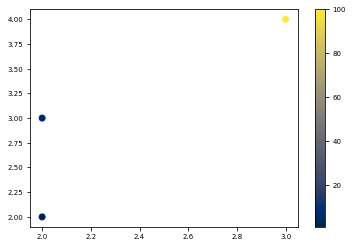

AttributeError: 'AxesSubplot' object has no attribute 'set_clim'

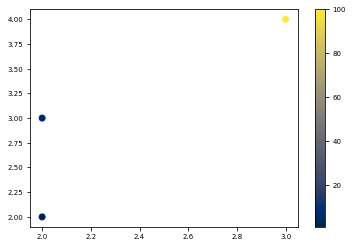

In [28]:
plt.scatter([2,2,3], [2,3,4], c=[1,6, 100])
plt.colorbar()
plt.show()


ax = plt.scatter([2,2,3], [2,3,4], c=[1,6, 100])
plt.colorbar()
plt.gca().set_clim(0,0.5)
plt.show()


In [23]:
help(plt.clim)

Help on function clim in module matplotlib.pyplot:

clim(vmin=None, vmax=None)
    Set the color limits of the current image.
    
    If either *vmin* or *vmax* is None, the image min/max respectively
    will be used for color scaling.
    
    If you want to set the clim of multiple images, use
    `~.ScalarMappable.set_clim` on every image, for example::
    
      for im in gca().get_images():
          im.set_clim(0, 0.5)



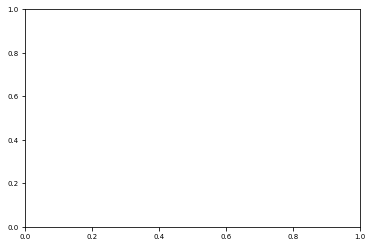

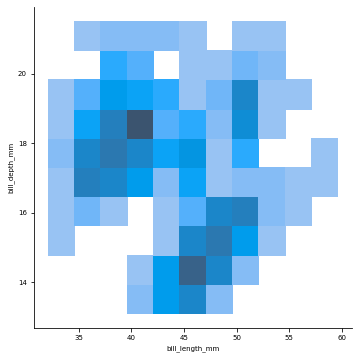

In [46]:
import seaborn as sns
penguins = sns.load_dataset("penguins")
penguins
sns.displot(penguins, x="bill_length_mm", y="bill_depth_mm")